**<h1 style="text-align: center;">A Deep 
$Q$-Learning Approach for TSP</h2>**

---

*<p style="text-align: center;">A tutorial by Jake Anderson (F132339) in partial furfillment of the module COC102</p>*

## Contents

<div style="column-count: 2;">

### Introduction
- [1.1 Abstract](#abstract)
- [1.2 Learning Objectives](#learning-objectives)

### Setup
- [2.1 Imports](#imports)
- [2.2 Gather location data](#gather-location-data)
- [2.3 Abstrating and visualising](#abstrating-and-visualising)

### Enviroment
- [3.1 What is TSP?](#what-is-tsp?)
- [3.2 TSP attributes](#tsp-attributes)

### Building DQN model
- [4.1 Model Structure](#model-structure)
- [4.1 Memory](#memory)

### Agent
- [5.1 Agent attributes](#agent-attributes)
- [5.2 Model training](#model-training)
- [5.3 Model updating](#model-updating)

### Visualisation & Conclusion
- [6.1 Visualisation](#visualisation)
- [6.2 Hyperparameter tuning](#hyperparameter-tuning)
- [6.3 Literature comparison](#literature-comparison)
</div>



## Introduction

<a id="abstract"><h3> Abstract</h3></a>
The Travelling Salesman Problem has been fascinating a range of disciplines for years due to its great versatility and complexity, while Q learning proves to be a ever popular tool for reinforcement learning. This tutorial looks to combine the two, namely using contemporary Deep Q networks in order to find efficient solutions to the Travelling Salesman Problem (TSP). It is hoped readers build an understanding for reinforcement learning as well as graph theory through the use of visualisation and interactive code. Please note this tutorial is not optimised for CUDA enabled devices.

<a id="learning-objectives"><h3>Learning Objectives</h3></a>
- (1) Get hands on experience working with large data sets
- (2) Learn about what it takes to solve TSP
- (3) Build reinforcement learning model (DQN)
- (4) Work with agents and training models for Q networks
- (5) Build understanding of how hyperparameters effect results

## Setup

<a id="imports"><h3>Imports</h3></a>
Before we do anything its important to import all of the libraries we will be working with. Please be aware that it is likely you will need to install them to your enviroment first, for those using an Anaconda enviroment use the conda install {package-name} otherwise use pip. For example 'pip install pandas'. 

In [3]:
# Data handling
import pandas as pd
import numpy as np
from collections import namedtuple, deque
import random

# Visualisation
import matplotlib.pyplot as plt
import imageio
import geopandas 
import warnings
import os
from tabulate import tabulate
from IPython.display import display, Image

# Model creation tools
from scipy.spatial.distance import cdist
from haversine import haversine
import torch                        
import torch.nn as nn
import torch.optim 
import torch.nn.functional as F

<a id="gather-location-data"><h3>Gather location data</h3></a>
Now we have the appropriate libraries we can now fetch our data. For this we will be using a pre made data set from Geopandas storing the physical location of cities and landmasses across the world *(however feel free to experiment with other data sources)*.  

In [15]:
# [1]
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))   
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))  # Get the city coordinates

cities    # Take a peek at data (dataframe)

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)
...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731)
239,São Paulo,POINT (-46.62697 -23.55673)
240,Sydney,POINT (151.21255 -33.87137)
241,Singapore,POINT (103.85387 1.29498)


<a id="abstrating-and-visualising"><h3>Abstrating and visualising</h3></a>
As seen above the city data provided is incredibly valuable for the task however has a few slight issues. The first being its a very large data set and to run our model on all of these points may take a very long time hence we will need to reduce this to a reasonable size. There is also the issue of the city location being potentially unclear to visualise in terms of all other locations.   
Lets try and solve these issues by using a subset of the data and using matplotlib to visualise the location of these cities.

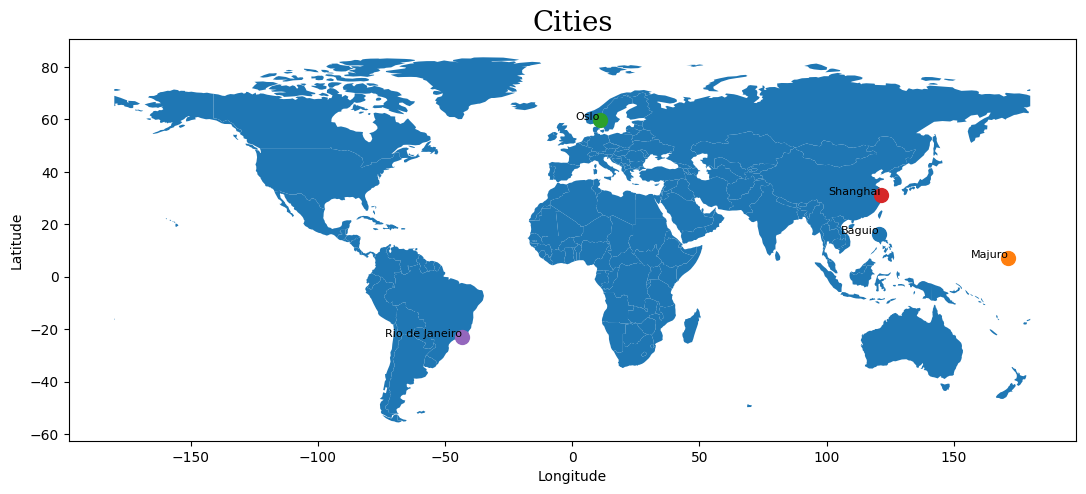

In [16]:
%matplotlib inline
NUM_CITIES = 5  # Feel free to change -> using 5 for faster computation
TITLE_FONT = {'family':'serif','color':'black','size':20} # [7]
warnings.filterwarnings('ignore')

cities = cities.sample(n=NUM_CITIES, random_state=42)   # Get random subset of cities in the dataframe

def create_plot(ax,world):  # Plot cities on map 
    world = world[(world.pop_est > 0) & (world.name != "Antarctica")]   # Get rid of non populated countries
    world.plot(ax=ax)
    for i, city in cities.iterrows():
        ax.scatter(city.geometry.x, city.geometry.y, s=100)  
        ax.text(city.geometry.x, city.geometry.y, city['name'], fontsize=8, ha='right')     
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return ax

fig, ax = plt.subplots(figsize=(13, 13))
create_plot(ax,world)
plt.title('Cities', fontdict = TITLE_FONT); 


The final issue with the dataset is that we are not explicitly given the distances between these cities. We can calculate the haversine distances which is useful for obtaining the angular distance between two points on the globe and then store them in an adjacency matrix in order to store them all in a consise and versatile way (see below). We may also want to see what this looks like so we can add these to the map created above.  
$$D(x, y)=2 \arcsin \left[\sqrt{\sin ^2\left(\left(x_{\text {lat }}-y_{\text {lat }}\right) / 2\right)+\cos \left(x_{\text {lat }}\right) \cos \left(y_{\text {lat }}\right) \sin ^2\left(\left(x_{\text {lon }}-y_{\text {lon }}\right) / 2\right)}\right]$$

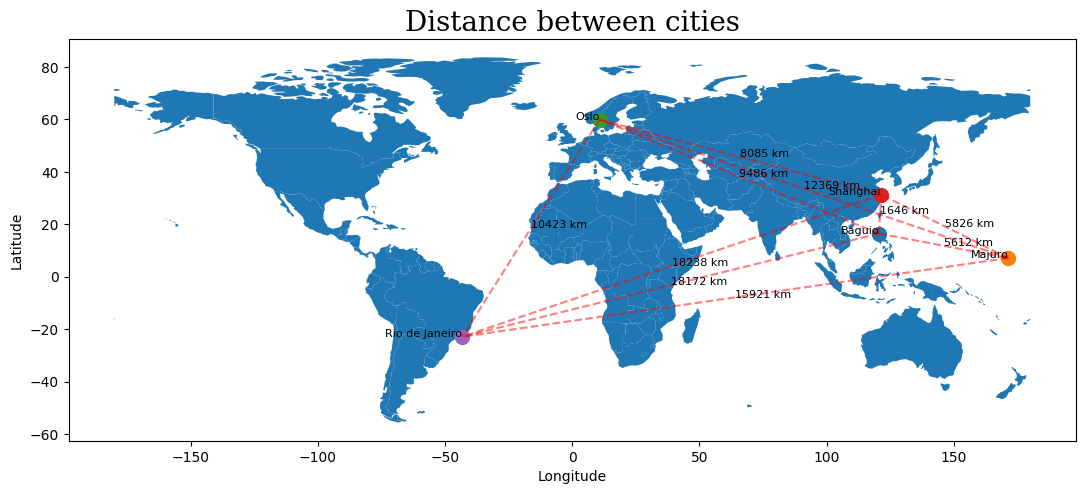

In [17]:
# Use cdist to get distances between each city -> store as adjancy matrix for ease of use ([5])
distances = cdist(cities.geometry.apply(lambda geom: (geom.y, geom.x)).tolist(),cities.geometry.apply(lambda geom: (geom.y, geom.x)).tolist(),metric=haversine) 

distances = distances.astype(int)   # Otherwise we get long floats

fig, ax = plt.subplots(figsize=(13, 13))
ax = create_plot(ax,world)
x_values = cities.geometry.x.values
y_values = cities.geometry.y.values

for i in range(NUM_CITIES):
    for j in range(i + 1, NUM_CITIES):
        if i != j:              # Dont care for the distance between city and itself (0 km)
            cost = distances[i, j]
            ax.plot([x_values[i], x_values[j]], [y_values[i], y_values[j]], 'k-', alpha=0.5, linestyle='dashed', color='red')
            ax.text((x_values[i] + x_values[j]) / 2, (y_values[i] + y_values[j]) / 2, f'{cost} km', fontsize=8)

plt.title('Distance between cities', fontdict = TITLE_FONT) 
plt.show()

## Enviroment
We have processed all of our data and our ready to dive in ! But one big question remains, what actually is TSP?

<a id="what-is-tsp?"><h3>What is TSP?</h3></a>
Imagine you are a salesman and what to visit a list of cities once and then return to where you started while travelling the least amount of distance. Formally consider some $G=(V,E)$ such that for any given $v_i \in V$ you want to find some $r^* = e(v_{i},v_{i+1}), e(v_{i+1},v_{i+2}) ... e(v_{n},v_{i})$ (a Hamiltonian Cycle) s.t $W(r^*) =  \min_{w} W(r)$ [6]. This is often referred to as the Travelling Salesman Problem and poses the question in our case of given our subset cities what is the shortest way to travel to each one and return to our start without re visiting any previous city.

<a id="tsp-attributes"><h3>TSP attributes</h3></a>
Lets begin by creating the enviroment for our model i.e what exactly the agent (our model training algorithm) will interact and be bounded to. We can imagine our enviroment in its simplist sense as a graph in which verticies are cities, edges are connections between cities and weights are the distances hence we store this data within our enviroment. We also look towards the problem ahead and consider what else we may need: 

- States
    - Important to keep track of where we have visited and the distance its taken the current distance and if we have completed a cycle yet
- An Inital State 
    - Get an inital city (here we do it randomly) and set distance 0 and visited to the inital city
- Validation
    - We want a way of checking if we have a valid cycle otherwise we can ignore it and restart
- Reward function
    - The shorter the route the better the reward hence the reward should be inversely proportional to the distance
- Tools for obtaining graph attributes
    - We will be needing to access the enviroment a lot so useful to make it accessible to use (i.e create getter functions)

In [18]:
class TSPEnvironment:   # [6]
    def __init__(self,distances):
        self.V = len(distances) # The number of nodes -- Cities
        self.distances = torch.tensor(distances, dtype=torch.float32) # Easier to handle 
        self.reset()

    def reset(self):       
        self.current = random.randint(0,self.V-1)   # City we are in -- set to random for ease
        self.visited = [self.current]   # Cities we have been
        self.reward = 0   
        self.get_state()    

    def next(self,new_city): # Check if Hamiltonian and add new state if so
        self.current = new_city # Update current city
        if (len(self.visited) < self.V and new_city not in self.visited) or (len(self.visited) == self.V and self.visited[0] == new_city): 
            self.visited.append(self.current) #Store history for current iteration
        else:
            self.reset()    # Reset iteration if violation of cycle
        return self.get_state_tensor(), self.reward, self.get_state()
    
    def get_reward(self):
        current_reward = 0          # Reward from current state
        if len(self.visited) >= 2:
            prev_city = self.visited[-2]              
            curr_city = self.visited[-1]           
            current_reward = self.reward + distances[prev_city][curr_city]
        current_reward *= -0.01    #Negative as minimisation problem    // normalise reward 
        self.reward += int(current_reward)      # Cumulative reward
        return int(current_reward)                    

    def get_state(self):
        complete = 1 if self.V + 1 == len(self.visited) else 0      #Have we got a graph that = length of hamitonian cycle
        current_reward = self.get_reward()
        reward = self.reward
        state = {'current_city': self.current, 'visited': self.visited, 'current_reward': current_reward,'cumulative_reward': reward, 'complete': complete}
        return state
    
    def get_state_tensor(self):     # Torch model takes tensor so convert state to tensor
        state = self.get_state()
        # Only need to convert things relevant to model, i.e dont need visited (also hard to handle as array)
        current_city_tensor = torch.tensor([int(state['current_city'])], dtype=torch.long)
        current_reward_tensor = torch.tensor([state['current_reward']], dtype=torch.float32)
        cumulative_reward_tensor = torch.tensor([state['cumulative_reward']], dtype=torch.float32)
        complete = torch.tensor([state['complete']], dtype=torch.long)
        state_tensor = torch.cat((current_city_tensor, current_reward_tensor, cumulative_reward_tensor,complete), dim=0).view(1, -1).to(torch.long)    #Change shape so model can accept it as input
        return state_tensor
 
    def get_nodes(self):
        return self.V

    def get_distances(self):
        return self.distances


## Building Deep Q model

<a id="model-structure"><h3>Model Structure</h3></a>
Before building our model its important to understand what exactly Deep Q and reinforcement is. We can think of reinforcement learning (RL) as a reward maximisation problem in which an agent $Ag$ looks to perform some series of actions $a \in A$ (sometimes called policy) that yield a state $s \in S$ s.t $s$ has the greatest reward. Q learning is simply a form of RL in which our agent $Ag$ looks to learn the best performing actions $a$ (based of reward) for any given state $s$ (known as $Q$ values), from here as time goes on its hoped the agent will converge to find the optimal policy [9]. Formally What are model is aiming to achieve is given a set of states $S$ (in our case visited cities and current distance) and acitons $A$ (potential cities we could go to) what is the expected rewards (distance) we will achieve for taking each ($Q$ values):
$$ Q : S \times A \to \mathbb{R} $$
The Deep aspect comes from using a multi layer neural network in order to achieve this goal which we will create below: 

In [19]:
class DQN(nn.Module):   # [4]
    def __init__(self, n_nodes, dimension_size):
        super(DQN, self).__init__()
        self.n_nodes = n_nodes
        self.dimension_size = dimension_size        # Hidden layer size
        self.embedding = nn.Embedding(n_nodes, dimension_size)
        self.lstm = nn.LSTMCell(dimension_size + 2, 64)  # +2 as current node embeddings + current and cumulative reward
        self.output = nn.Linear(64, n_nodes)  # Ouput size = n_nodes as n rewards is our output

    def forward(self, state, hidden=None):      # Deep nn forward pass
        current_node, current_reward, cumulative_reward,complete = state.unbind(1)      # 'Complete' will always be 0 here hence not used
        embedded_nodes = self.embedding(current_node)
        concatenated_input = torch.cat((embedded_nodes, current_reward.unsqueeze(1), cumulative_reward.unsqueeze(1)), dim=1)
        hidden = self.lstm(concatenated_input, hidden)  # LSTM used due to it being sequential (list of cities) data 
        lstm_output = hidden[0]       
        nodes = F.relu(lstm_output)     # Activate LSTM layer using ReLu function
        value = self.output(nodes)
        return value, hidden


<a id="memory"><h3>Memory</h3></a>
As mentioned above we are interested in our model 'learning', we can look to achieve this by storing previous states in memory and then later using it to review (and hopefully improve) the weights for our model above.  
Below we use a class to add and sample previous and next states, actions and the rewards for the given state (distance). We also set a capacity to ensure we have enough samples but not too many leading to excessive memory useage.

In [20]:
# Store history as tensor as its more efficient than recalculating each time  ([2])
History = namedtuple('History', ('state_tensor', 'action', 'reward', 'next_state_tensor','hidden'))       

class ReplayMemory(object): # [4]
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)        # Maxlen means we dont need to check if we hit capacity when adding

    def add(self, *args):
        self.memory.append(History(*args))      
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

## Agent

<a id="agent-attributes"><h3>Agent attributes</h3></a>
We use the term (intelligent) agent to describe *"Anything that can be viewed as perceiving its environment (TSP in our case) through sensors and acting upon that environment (travelling to cities) through actuators"* [10] which in our case looks to reduce the total distances of our hamiltonian cycle.  
Firstly, from definition we should consider passing our enviroment (TSP class) and model (above) to our agent so it can act within the enviroment. We next need to consider how to train our model through our agent.

<a id="model-training"><h3>Model training</h3></a>
In order for our agent to produce the optimal route (policy) we must train it for some number of epoches (rounds) within the enviroment. We do this by starting at our inital state $s_0$ (defined within the enviroment) and gradually move state to state taking the percieved best action $a$ (via $Q$ values) through our DQN. There is however a few things we must consider:  
- We only care for valid cycles
    - Hence we want to reset our enviroment on each violation
- We will want to update memory with each state 
- Convergence
    - If we keep getting the same expected reward (past some threshold) we can assume we have found $r^*$
- Visualisation
- Exploration vs exploitation
    - We choose a random action if some given threshold (epsilon is met) other choose best (Q value)

<a id="model-updating"><h3>Model updating</h3></a>
Once we have sufficient history (certain batch size) we can update our weights, this can be done by comparing our current $Q$ values to the expected optiimal via the Belman equation below (refer to [11] for more):  
$$ Q(s, a) = E[R + γ * max[Q(s', a')] | s, a] $$
We then use the Adam optimiser to apply these new weights (backpropogate). 


In [21]:
class Agent:
    def __init__(self, model, environment ,memory_capacity=1000, batch_size=32, gamma=0.99, learning_rate=0.001, convergence_threshold=10, create_plot=create_plot,world=world):
        # For training
        self.model = model
        self.environment = environment  
        self.replay_memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size
        self.gamma = gamma      # Discount factor in Belman formula
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)    
        self.hidden = None  
        # For checking convergance of policy
        self.convergence_threshold = convergence_threshold
        self.best_cumulative_reward = float('-inf')
        self.consecutive_no_improvement = 0
        # For plotting model behaviour
        self.create_plot = create_plot
        self.world = world

    def plot_epoch(self,x_values, y_values, solution, title, filename):     # Plot the policy after each epoch
        TITLE_FONT = {'family':'serif','color':'black','size':20}
        fig, ax = plt.subplots(figsize=(13, 13))
        ax = self.create_plot(ax,self.world)
        for i in range(len(solution) - 1):
            connected_node = solution[i + 1]
            node = solution[i]
            x_node, y_node = x_values[node], y_values[node]
            x_connected, y_connected = x_values[connected_node], y_values[connected_node]
            ax.plot([x_node, x_connected], [y_node, y_connected], 'k-', alpha=0.5, linestyle='-', color='red')
            ax.text((x_values[node] + x_values[connected_node]) / 2, (y_values[node] + y_values[connected_node]) / 2, f'Trip #{i+1}', fontsize=8,color='orange')
        ax.plot([x_values[solution[-1]], x_values[solution[0]]], [y_values[solution[-1]], y_values[solution[0]]], 'k-', alpha=0.5, linestyle='-', color='red')
        plt.title(title, fontdict = TITLE_FONT)
        plt.savefig(filename, bbox_inches='tight')
        plt.close()


    def train(self, epochs,x_values,y_values):
        output_folder = 'output/'
        os.makedirs(output_folder, exist_ok=True)       # Store policies (for gif)
        image_files = []
        for epoch in range(epochs):
            self.environment.reset()        # Not using old state
            rewards = []
            state = self.environment.get_state()
            state_tensor = self.environment.get_state_tensor()
            self.hidden = None  
            # Keep going until we obtain a valid solution (i.e hamiltonian graph)
            while not state['complete']:
                action = self.get_action(state_tensor)  # Get action (i.e what state to choose)
                next_state_tensor, reward, next_state = self.environment.next(action)   
                self.replay_memory.add(state_tensor, action, reward, next_state_tensor, self.hidden)    # Update memory 
                if len(self.replay_memory) >= self.batch_size:      # Check if we have enough data in order to get samples
                    self.update()
                state = next_state  # Update states
                state_tensor = next_state_tensor
            
            if self.check_improvement(state,epoch):
                break
            # Plot solution (policy) for current epoch
            title = f"Epoch {epoch+1}, Distance Travelled: {-state['cumulative_reward'] * 100} km"
            filename = os.path.join(output_folder, f'tsp_solution_epoch_{epoch}.png')
            image_files.append(filename)
            self.plot_epoch(x_values, y_values, state['visited'], title, filename)
            rewards.append(state['cumulative_reward'])        
        
        return rewards, image_files
    

    def check_improvement(self,state, epoch):          # Check if policies converge -> prevents uncessary epochs
        if state['cumulative_reward'] > self.best_cumulative_reward:        # Check if the new reward (distance) is greater than what we currently have
            self.best_cumulative_reward = state['cumulative_reward']
            self.consecutive_no_improvement = 0
        else:
            self.consecutive_no_improvement += 1            
        if self.consecutive_no_improvement >= self.convergence_threshold:   # If we have converged past our threshold halt
            print(f"Converged after {epoch + 1} epochs.")
            return True
        return False

    def get_action(self, state):
        self.model.train()  # Set model to training mode
        epsilon = 0.1  # Eploration threshold
        if random.uniform(0, 1) < epsilon:  # If less than threshold explore else exploit
            action = random.randint(0, self.model.n_nodes - 1)  # Get random next state (exploration)
        else:
            with torch.no_grad():
                q_values, self.hidden = self.model(state, self.hidden)      
            action = torch.argmax(q_values).item()  # Choose state (action) with best reward (exploitation)
        return action

    def update(self):   # Update weights (backpropogate) -> Learn from samples 
        samples = self.replay_memory.sample(self.batch_size)    # Get random samples 
        # Upack samples 
        states, actions, rewards, next_states, hiddens = zip(*[(sample.state_tensor, sample.action, sample.reward, sample.next_state_tensor, sample.hidden) for sample in samples])
        q_rewards = []
        target_rewards = []
        for i in range(len(states)):
            target = rewards[i]     # Target = Belman reward
            if states[i][0][-1].item() != 1:        # Keep checking while we are not in a end state
                # Obtain Q values for current state and next state
                q_values, _ = self.model(states[i], None)  
                next_q_values, _ = self.model(next_states[i], None)  
                target += rewards[i] + self.gamma * next_q_values.max(dim=1).values # Apply Belman formula to target
                target_rewards.append(target)
                q_rewards.append(q_values)
        states = torch.stack(states)    
        q_rewards = torch.stack(q_rewards)
        target_rewards = torch.stack(target_rewards)
        q_values_selected = q_rewards.gather(2, torch.tensor(actions).view(-1, 1).unsqueeze(2))    # Get the Q values from the actions sampled
        loss = F.mse_loss(q_values_selected, target_rewards.unsqueeze(2))   # Check the loss of the sampled Q values and the target Q values (from Belman formula)
        # Run Adam optimiser on model with the loss just calculated
        self.optimizer.zero_grad()
        loss.backward()             # Readjust weights of DQN based on loss (backprop)
        self.optimizer.step()       


We can now run our agent and see the result it produces, please note that the provided hyperparameters are variable hence please feel free to experiment with varying sizes. 

In [22]:
env = TSPEnvironment(distances)
model = DQN(len(distances), 128)
# Hyperparameters (feel free to change)
memory_capacity = 1000  # Capacity of replay memory
batch_size = 32         # Size of memory samples 
gamma = 0.99            # Reward discount for Belman formula
learning_rate = 0.001   # For optimiser (Adam)
num_epochs = 50

# Create agent 
agent = Agent(model, env, memory_capacity, batch_size, gamma, learning_rate)
# Train model
result = agent.train(num_epochs,x_values,y_values)

Converged after 16 epochs.


## Visualisation & Conclusion

<h3><a id="visualisation"> Visualisation</a></h3>
We use Imageio here to create a GIF for the route created after each epoch, run the cell below to see how it looks !

/var/folders/1d/xnj26ty16x97vch4mm8vxb780000gn/T/ipykernel_99654/841088824.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in image_files]


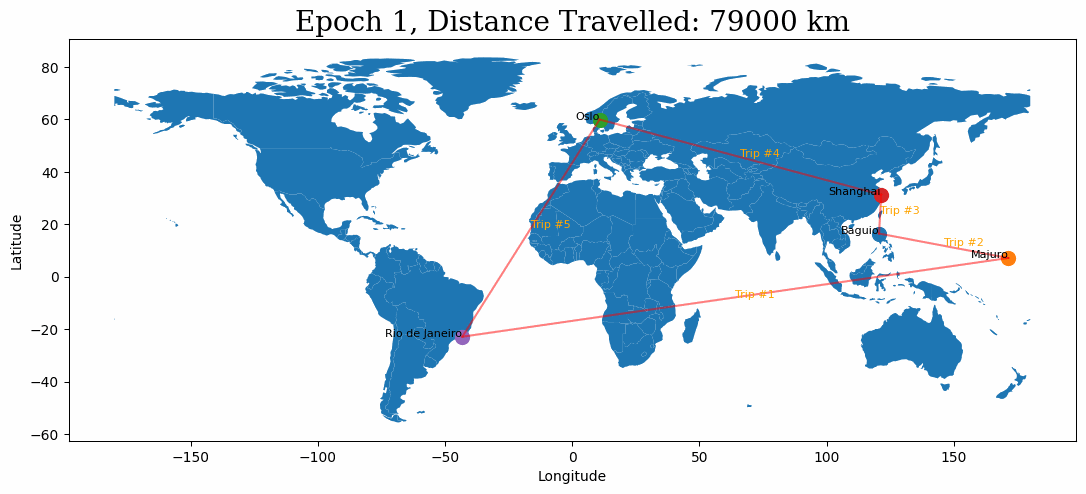

In [7]:
# Create visualisation ([3])


def create_gif(image_files, gif_filename):  
    images = [imageio.imread(filename) for filename in image_files]
    imageio.mimsave(gif_filename, images, duration=1000)

gif_filename = 'tsp_solutions.gif'

create_gif(result[1], gif_filename)
with open(gif_filename, 'rb') as f:
    display(Image(data=f.read(), format='png'))

<a id="hyperparameter-tuning"><h3>Hyperparameter tuning</h3></a>
The following presents how varying parameters impact our overall performance,
- $\gamma$ ($\in [0,1]$) is known as the 'discount factor', this determines the importance of future rewards 
    - The higher the value the more likely we can about minimising long-term distances compared to the immediate distance.
- Learning rate (step size) is the ratio of parameter update to gradient/momentum/velocity [12]  

Note we can also change sizes of epoches but please remember convergence looks to reduce the need of greater number of episodes.

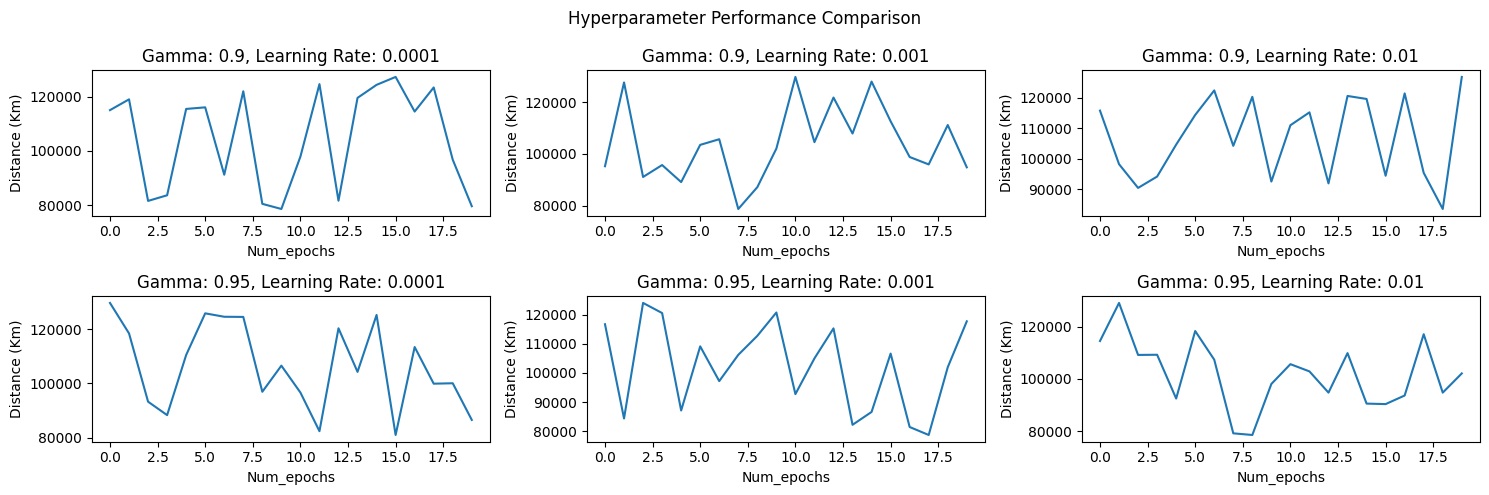

Results in table form:
Hyperparameters                       Distance
----------------------------------  ----------
Gamma: 0.9, Learning Rate: 0.0001      78545.8
Gamma: 0.9, Learning Rate: 0.001       78762.1
Gamma: 0.9, Learning Rate: 0.01        83582.1
Gamma: 0.95, Learning Rate: 0.0001     81003.2
Gamma: 0.95, Learning Rate: 0.001      78720.2
Gamma: 0.95, Learning Rate: 0.01       78541.3


In [13]:
# Hyperparameters -> See what happens when you change these !
env = TSPEnvironment(distances)
model = DQN(len(distances), 128)
gamma_values = [0.9, 0.95]  
num_epochs = 20
learning_rate_values = [0.0001, 0.001,0.01]        
fig, axs = plt.subplots(len(gamma_values), len(learning_rate_values), figsize=(15, 5))

results = []

for i, gamma in enumerate(gamma_values): 
    for j, learning_rate in enumerate(learning_rate_values):
        agent = Agent(model, env, gamma=gamma, learning_rate=learning_rate)
        res = agent.train(num_epochs,x_values,y_values)
        res= res[0] * - 1          
        axs[i, j].plot(np.arange(len(result)), result)
        axs[i, j].set_xlabel('Num_epochs')
        axs[i, j].set_ylabel('Distance (Km)')
        axs[i, j].set_title(f"Gamma: {gamma}, Learning Rate: {learning_rate}")
        results.append([f"Gamma: {gamma}, Learning Rate: {learning_rate}", res[-1]])

plt.suptitle('Hyperparameter Performance Comparison', fontdict = TITLE_FONT,size = 20) 
 
plt.tight_layout()
plt.show()
print("Results in table form:")
print(tabulate(results, headers=["Hyperparameters", "Distance"]))   #Table form 

<a id="literature-comparison"><h3>Literature comparison</h3></a>
<table>
  <tr>
    <th>Article</th>
    <th>Pros</th>
    <th>Cons</th>
  </tr>
  <tr>
    <td>1. <a href="https://github.com/nisengweregis/geopandas/blob/main/mapping_with_geopandas.ipynb" id="article1">Routing Traveling Salesmen on Random Graphs using Reinforcement Learning, in PyTorch</a> - Julien Herzen [2]</td>
    <td>- Impressive results (almost always beating random routes)<br>- Uses contemporary PyTorch tooling</td>
    <td>- At points hard to follow (complex)<br>- Minimal effort in hyperparameter tuning (as mentioned by the article)</td>
  </tr>
  <tr>
    <td>2. <a href="https://github.com/unit8co/medium-tsp/blob/master/RL%20Traveling%20Salesman.ipynb" id="article2">Optimizing delivery with Reinforcement Learning</a> - Theo Alves Da Costa [3]</td>
    <td>- Great visualization<br>- Simplistic (easy to follow)</td>
    <td>- Minimal explanation<br>- Doesn't exploit DQN (as discussed by the author)</td>
  </tr>
</table>



## References

- [1] https://github.com/nisengweregis/geopandas/blob/main/mapping_with_geopandas.ipynb
    - Used to get world map and cities (dataset)
- [2] https://github.com/unit8co/medium-tsp/blob/master/RL%20Traveling%20Salesman.ipynb
    - Model inspiration 
- [3] https://github.com/TheoLvs/reinforcement-learning/blob/master/5.%20Delivery%20Optimization/delivery.py
    - Gif visualisation inspiration 
- [4] https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    - Template for DQN and helped understand pytorch RL
- [5] https://stackoverflow.com/questions/56043475/pairwise-distance-between-collections-of-points-with-latitude-and-longitude
    - Knowledge for distances
- [6] https://en.wikipedia.org/wiki/Travelling_salesman_problem
    - Enviroment specification 
- [7] https://www.w3schools.com/python/matplotlib_labels.asp
    - Plot labelling 
- [8] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
    - Distance calculation
- [9] https://en.wikipedia.org/wiki/Q-learning
    - Q Learning information
- [10] https://aima.cs.berkeley.edu/
    - Definition of agent
- [11] https://www.linkedin.com/pulse/bellman-equation-yeshwanth-n/
    - Belman equation explained
- [12] https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html.
    - Learning rate for Adam